## **Model and Evaluation**

## Objectives

* Fit and evaluate a classification model to predict the sales price.


## Inputs

* outputs/datasets/collection/SalesRecord.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales/jupyter_notebooks'

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales'

---

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/SalesRecord.csv"))

print(df.shape)
df.head(10)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [50]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ('median', MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'BedroomAbvGr','GarageYrBlt', 
                                                'LotFrontage', 'MasVnrArea'])),

        ('categorical_imputer', CategoricalImputer(imputation_method='missing',
                                                  fill_value='Missing',
                                                  variables=['GarageFinish', 'BsmtFinType1'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'GarageFinish', 'KitchenQual', 'BsmtFinType1'])),
        
        ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF',])),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('categorical_imputer',
                 CategoricalImputer(variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'GarageFinish',
                                           'KitchenQual', 'BsmtFinType1'])),
                ('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF']))])

---

# ML Pipline for Modeling and Hyperparameters

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [52]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

---

## Split and Train

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


---

## Handle Target Inbalance

In [9]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


In [10]:
import pandas as pd
data = pd.concat([X_train, pd.Series(y_train, name='y')], axis=1)
class_counts = data['y'].value_counts()

print("Class Distribution:")
print(class_counts)

minority_class_count = class_counts.min()
print(f"\nMinority Class Count: {minority_class_count}")


Class Distribution:
140000    18
135000    14
155000    11
130000    10
180000     9
          ..
68400      1
185500     1
556581     1
159895     1
234000     1
Name: y, Length: 573, dtype: int64

Minority Class Count: 1


RandomOverSampler from imblearn to balance Train Set target

In [11]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='auto', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10314, 21) (10314,) (292, 21) (292,)


---

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [12]:
models_search = {
    "LogisticRegression": LogisticRegression(solver='liblinear', random_state=0)
}

params_search = {
    "LogisticRegression": {}
}

In [15]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score, average='weighted'),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.458499,0.468514,0.487276,0.010517


In [17]:
models_search = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
}

params_search = {
    "DecisionTreeClassifier": {},
}

In [18]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score, average='weighted'),
           n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [19]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,DecisionTreeClassifier,0.978695,0.988413,0.996373,0.006741


In [15]:
best_model = grid_search_summary.iloc[0,0]
best_model

'DecisionTreeClassifier'

In [16]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

In [17]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model', DecisionTreeClassifier(random_state=0))])

---

## Assess feature importance

In [18]:
X_train.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,1828,0.0,3.0,0,48,0,1774,774,0,2007.0,...,0,11694,90.0,452.0,108,5,9,1822,2007,2007
1,894,0.0,2.0,1,0,1,894,308,1,1962.0,...,1,6600,60.0,0.0,0,5,5,894,1962,1962
2,964,0.0,2.0,1,713,2,163,432,0,1921.0,...,1,13360,80.0,0.0,0,7,5,876,1921,2006
3,1689,0.0,3.0,1,1218,3,350,857,2,2002.0,...,0,13265,69.0,148.0,59,5,8,1568,2002,2002
4,1541,0.0,3.0,1,0,1,1541,843,2,2001.0,...,0,13704,118.0,150.0,81,5,7,1541,2001,2002


* With the current model, we can assess with `.features_importances_`

* These are the 10 most important features in descending order. The model was trained on them: 
['GarageArea', 'LotArea', '1stFlrSF', 'BsmtUnfSF', 'GrLivArea', 'LotFrontage', 'BsmtFinSF1', 'TotalBsmtSF', 'OpenPorchSF', '2ndFlrSF']


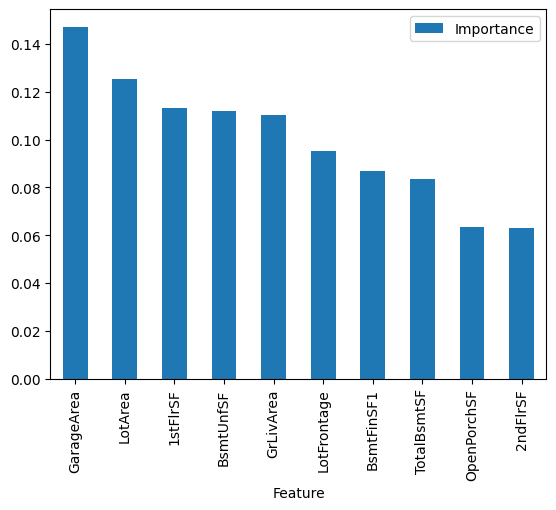

In [26]:
import matplotlib.pyplot as plt
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

# Step 3: Refit pipeline with best features

In [65]:
best_features

['GarageArea',
 'LotArea',
 '1stFlrSF',
 'BsmtUnfSF',
 'GrLivArea',
 'LotFrontage',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'OpenPorchSF',
 '2ndFlrSF']

New Pipeline for DataCleaning And FeatureEngineering

In [67]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        
    ('median', MeanMedianImputer(imputation_method='median', variables=['2ndFlrSF','LotFrontage'])),

    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [68]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1774, i

## Split Train Test Set, considering only with best features

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


We filter only the most important variables

In [70]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(1168, 10) (1168,) (292, 10) (292,)


,GarageArea,LotArea,1stFlrSF,BsmtUnfSF,GrLivArea,LotFrontage,BsmtFinSF1,TotalBsmtSF,OpenPorchSF,2ndFlrSF
618,774,11694,1828,1774,1828,90.0,48,1822,108,0.0
870,308,6600,894,894,894,60.0,0,894,0,0.0
92,432,13360,964,163,964,80.0,713,876,0,0.0


## Handle Target Imbalance

In [71]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 10) (1168,) (292, 10) (292,)


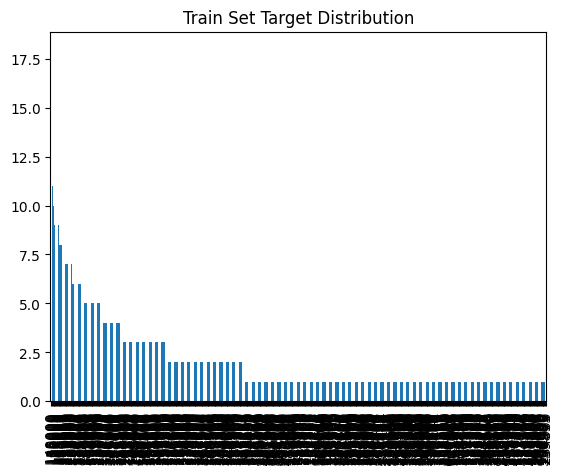

In [72]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

RandomOverSampler from imblearn to balance Train Set target

In [74]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='auto', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10314, 10) (10314,) (292, 10) (292,)


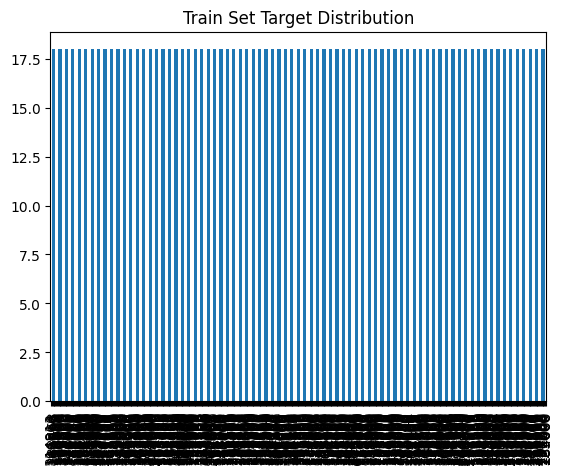

In [75]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

---

## Grid Search CV: Sklearn

We are using the same model from  the last GridCV search

In [76]:
models_search

{'DecisionTreeClassifier': DecisionTreeClassifier(random_state=0)}

And the best parameters from the last GridCV search 

In [77]:
best_parameters

['GarageArea',
 'LotArea',
 '1stFlrSF',
 'BsmtUnfSF',
 'GrLivArea',
 'LotFrontage',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'OpenPorchSF',
 '2ndFlrSF']

In [81]:
models_search = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
}

params_search = {
    "DecisionTreeClassifier": {},
}

In [84]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(f1_score, average='weighted'),
                 n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [85]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,DecisionTreeClassifier,0.977986,0.988627,0.996365,0.006965


Define the best clf pipeline

In [86]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=0))])

---

## Assess feature importance

* These are the 10 most important features in descending order. The model was trained on them: 
['GarageArea', 'LotArea', '1stFlrSF', 'BsmtUnfSF', 'GrLivArea', 'LotFrontage', 'BsmtFinSF1', 'TotalBsmtSF', 'OpenPorchSF', '2ndFlrSF']


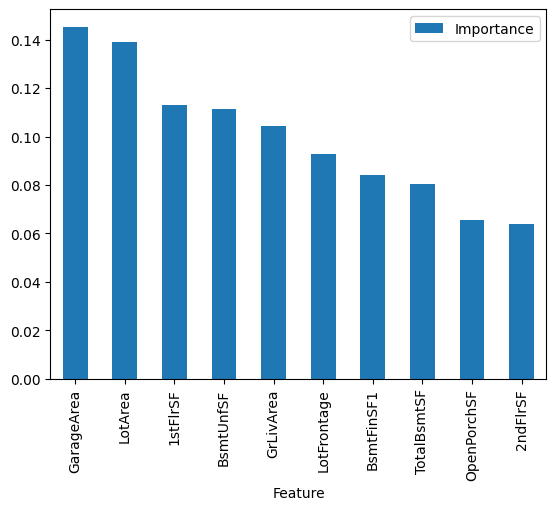

In [87]:
best_features = X_train.columns

df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

---

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [89]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_Sales/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

In [90]:
print(X_train.shape)
X_train.head()

(10314, 10)


,GarageArea,LotArea,1stFlrSF,BsmtUnfSF,GrLivArea,LotFrontage,BsmtFinSF1,TotalBsmtSF,OpenPorchSF,2ndFlrSF
0,774,11694,1828,1774,1828,90.0,48,1822,108,0.0
1,308,6600,894,894,894,60.0,0,894,0,0.0
2,432,13360,964,163,964,80.0,713,876,0,0.0
3,857,13265,1689,350,1689,69.0,1218,1568,59,0.0
4,843,13704,1541,1541,1541,118.0,0,1541,81,0.0


In [91]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [92]:
y_train

0        314813
1        109500
2        163500
3        271000
4        205000
          ...  
10309    755000
10310    755000
10311    755000
10312    755000
10313    755000
Name: SalePrice, Length: 10314, dtype: int64

In [93]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [94]:
print(X_test.shape)
X_test.head()

(292, 10)


,GarageArea,LotArea,1stFlrSF,BsmtUnfSF,GrLivArea,LotFrontage,BsmtFinSF1,TotalBsmtSF,OpenPorchSF,2ndFlrSF
529,484,32668,2515,816,2515,69.0,1219,2035,0,0.0
491,240,9490,958,238,1578,79.0,403,806,0,620.0
459,352,7015,979,524,1203,69.0,185,709,0,224.0
279,505,10005,1156,768,2022,83.0,392,1160,117,866.0
655,264,1680,525,525,1092,21.0,0,525,0,0.0


In [95]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [96]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [97]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

---

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [98]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'LotFrontage']))])

In [99]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_Sales/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [100]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier(random_state=0))])

In [101]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_Sales/v1/clf_pipeline_model.pkl']

## Feature Importance plot

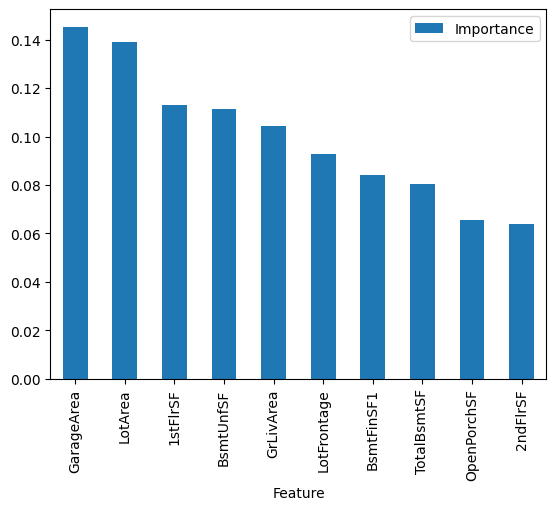

In [102]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

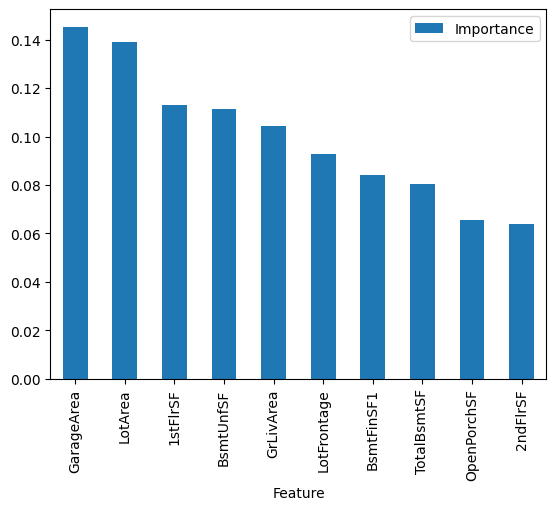

/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1774, i

In [103]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')